<a href="https://colab.research.google.com/github/DNdoma41/DNdoma41/blob/main/Praxix_6_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Libraries

In [1]:
!pip install textstat vaderSentiment scikit-learn textblob statsmodels --quiet

import re
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report, brier_score_loss
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
from sklearn.utils.class_weight import compute_class_weight
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import textstat
import statsmodels.api as sm
import statsmodels.formula.api as smf
np.random.seed(42)

# Loading DataSets

In [2]:

# loading  datasets
# label 0 = AI, 1 = Human
df_ai = pd.read_csv("/content/safe_phishing_dataset.csv")     # AI-generated emails
df_human = pd.read_csv("/content/enron.csv")  # Human-generated emails

# Displaying first 5 rows of AI Generated Dataset

In [3]:
df_ai.head()

,subject,html_body,label
0,Your Acme Cloud password reset request,"<!doctype html>\n<html>\n <body style=""font-f...",1
1,Lunch & Learn: Cyber Safety at Home,"<!doctype html>\n<html>\n <body style=""font-f...",0
2,Unusual sign-in activity detected from Chicago,"<!doctype html>\n<html>\n <body style=""font-f...",1
3,Welcome to Fabrikam Services! Getting started ...,"<!doctype html>\n<html>\n <body style=""font-f...",0
4,Welcome to Tailspin Apps! Getting started guide,"<!doctype html>\n<html>\n <body style=""font-f...",0


# Displaying first 5 rows of Human Generated Dataset

In [4]:
df_human.head()

,subject,body,label
0,"hpl nom for may 25 , 2001",( see attached file : hplno 525 . xls )\r\n- h...,0
1,re : nom / actual vols for 24 th,- - - - - - - - - - - - - - - - - - - - - - fo...,0
2,"enron actuals for march 30 - april 1 , 201","estimated actuals\r\nmarch 30 , 2001\r\nno flo...",0
3,"hpl nom for may 30 , 2001",( see attached file : hplno 530 . xls )\r\n- h...,0
4,"hpl nom for june 1 , 2001",( see attached file : hplno 601 . xls )\r\n- h...,0


# Renaming column name "body" from human generated email to "html_body"

In [5]:
df_human.rename(columns={"body":"html_body" }, inplace=True)

# Assigning labels to AI-generated and Human-Geberated emails, ai_generated = 0 and human_generated =1

In [6]:
df_ai['label'] = 0
df_human['label'] = 1

# Combining ai_generated and human_generated emails as df_combined

In [7]:
# combine datasets
df_combined= pd.concat([df_ai, df_human], ignore_index=True)

# Displaying Combined datasets

In [8]:
df_combined.head(10)

,subject,html_body,label
0,Your Acme Cloud password reset request,"<!doctype html>\n<html>\n <body style=""font-f...",0
1,Lunch & Learn: Cyber Safety at Home,"<!doctype html>\n<html>\n <body style=""font-f...",0
2,Unusual sign-in activity detected from Chicago,"<!doctype html>\n<html>\n <body style=""font-f...",0
3,Welcome to Fabrikam Services! Getting started ...,"<!doctype html>\n<html>\n <body style=""font-f...",0
4,Welcome to Tailspin Apps! Getting started guide,"<!doctype html>\n<html>\n <body style=""font-f...",0
5,2FA code inside (do not share),"<!doctype html>\n<html>\n <body style=""font-f...",0
6,Unusual sign-in activity detected from Seattle,"<!doctype html>\n<html>\n <body style=""font-f...",0
7,Thanks for your feedback,"<!doctype html>\n<html>\n <body style=""font-f...",0
8,Invoice INV-43010 overdue — confirm payment,"<!doctype html>\n<html>\n <body style=""font-f...",0
9,Invoice INV-79813 overdue — confirm payment,"<!doctype html>\n<html>\n <body style=""font-f...",0


# Checking for columns with missing data

In [9]:
df_combined.isnull().sum()

,0
subject,198
html_body,0
label,0


# Filling missing data using 'fillna("")'

In [10]:
df_combined["subject"] = df_combined["subject"].fillna("")

# Displaying Data to ensure missing data worked

In [11]:
print(df_combined.isnull().sum())

subject      0
html_body    0
label        0
dtype: int64


# Downloading combined dataset to a path titled "combined_email_dataset.csv" and showing the shape of data

In [12]:
output_path = "combined_email_dataset.csv"
df_combined.to_csv(output_path, index=False)

print(f"Combined dataset saved: {output_path}")
print(f"Shape: {df_combined.shape}")
print("Columns:", df_combined.columns.tolist())

Combined dataset saved: combined_email_dataset.csv
Shape: (54767, 3)
Columns: ['subject', 'html_body', 'label']


# Displaying Combined Dataset with filled missing values

In [13]:
df_combined

,subject,html_body,label
0,Your Acme Cloud password reset request,"<!doctype html>\n<html>\n <body style=""font-f...",0
1,Lunch & Learn: Cyber Safety at Home,"<!doctype html>\n<html>\n <body style=""font-f...",0
2,Unusual sign-in activity detected from Chicago,"<!doctype html>\n<html>\n <body style=""font-f...",0
3,Welcome to Fabrikam Services! Getting started ...,"<!doctype html>\n<html>\n <body style=""font-f...",0
4,Welcome to Tailspin Apps! Getting started guide,"<!doctype html>\n<html>\n <body style=""font-f...",0
...,...,...,...
54762,confidence is back,"hello ,\r\nmy boyfriend began having problems ...",1
54763,important information,love - potion for your darling is all you want...,1
54764,vys - make itnger,you have feelings of guilt and embarrassment ...,1
54765,the best thing come in large parcels,spur - m formula\r\nincrease sperm production ...,1


# Downloading Libraries

In [14]:
!pip install -U nltk
import numpy as np
import re
from bs4 import BeautifulSoup
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize

# Removing or stripping hmtl tags and spaces from subject and html_column and renaming columns as folowws "subject: clean_subject", "html_body: clean_body" and combining clean_subject and clean_body column as new column "text"

In [15]:
# df_combined must have columns: 'subject', 'html_body'
def strip_tags(x: str) -> str:
    if pd.isna(x):
        return ""
    txt = BeautifulSoup(str(x), "html.parser").get_text(" ")  # remove HTML
    return re.sub(r"\s+", " ", txt).strip()                    # collapse spaces

df_combined["clean_subject"] = df_combined["subject"].apply(strip_tags)
df_combined["clean_body"]    = df_combined["html_body"].apply(strip_tags)

# quick peek
print(df_combined[["clean_subject","clean_body"]].head(10))

                                       clean_subject                                         clean_body
0             Your Acme Cloud password reset request  Hi Alex, We noticed unusual activity on your E...
1                Lunch & Learn: Cyber Safety at Home  Hello Morgan, Thanks for being part of Fabrika...
2     Unusual sign-in activity detected from Chicago  Hi Riley, We noticed unusual activity on your ...
3  Welcome to Fabrikam Services! Getting started ...  Hello Taylor, Thanks for being part of Fabrika...
4    Welcome to Tailspin Apps! Getting started guide  Hello Alex, Thanks for being part of Northwind...
5                     2FA code inside (do not share)  Hi Jamie, We noticed unusual activity on your ...
6     Unusual sign-in activity detected from Seattle  Hi Alex, We noticed unusual activity on your A...
7                           Thanks for your feedback  Hello Sam, Thanks for being part of Tailspin A...
8        Invoice INV-43010 overdue — confirm payment  Hi Alex, W

# Displying df_combined with removed html tags

In [16]:
df_combined

,subject,html_body,label,clean_subject,clean_body
0,Your Acme Cloud password reset request,"<!doctype html>\n<html>\n <body style=""font-f...",0,Your Acme Cloud password reset request,"Hi Alex, We noticed unusual activity on your E..."
1,Lunch & Learn: Cyber Safety at Home,"<!doctype html>\n<html>\n <body style=""font-f...",0,Lunch & Learn: Cyber Safety at Home,"Hello Morgan, Thanks for being part of Fabrika..."
2,Unusual sign-in activity detected from Chicago,"<!doctype html>\n<html>\n <body style=""font-f...",0,Unusual sign-in activity detected from Chicago,"Hi Riley, We noticed unusual activity on your ..."
3,Welcome to Fabrikam Services! Getting started ...,"<!doctype html>\n<html>\n <body style=""font-f...",0,Welcome to Fabrikam Services! Getting started ...,"Hello Taylor, Thanks for being part of Fabrika..."
4,Welcome to Tailspin Apps! Getting started guide,"<!doctype html>\n<html>\n <body style=""font-f...",0,Welcome to Tailspin Apps! Getting started guide,"Hello Alex, Thanks for being part of Northwind..."
...,...,...,...,...,...
54762,confidence is back,"hello ,\r\nmy boyfriend began having problems ...",1,confidence is back,"hello , my boyfriend began having problems wit..."
54763,important information,love - potion for your darling is all you want...,1,important information,love - potion for your darling is all you want...
54764,vys - make itnger,you have feelings of guilt and embarrassment ...,1,vys - make itnger,you have feelings of guilt and embarrassment h...
54765,the best thing come in large parcels,spur - m formula\r\nincrease sperm production ...,1,the best thing come in large parcels,spur - m formula increase sperm production 500...


# Check for Duplicate Values

In [17]:
#check duplicate values
df_combined.duplicated().sum()

np.int64(0)

# Importing Libraries

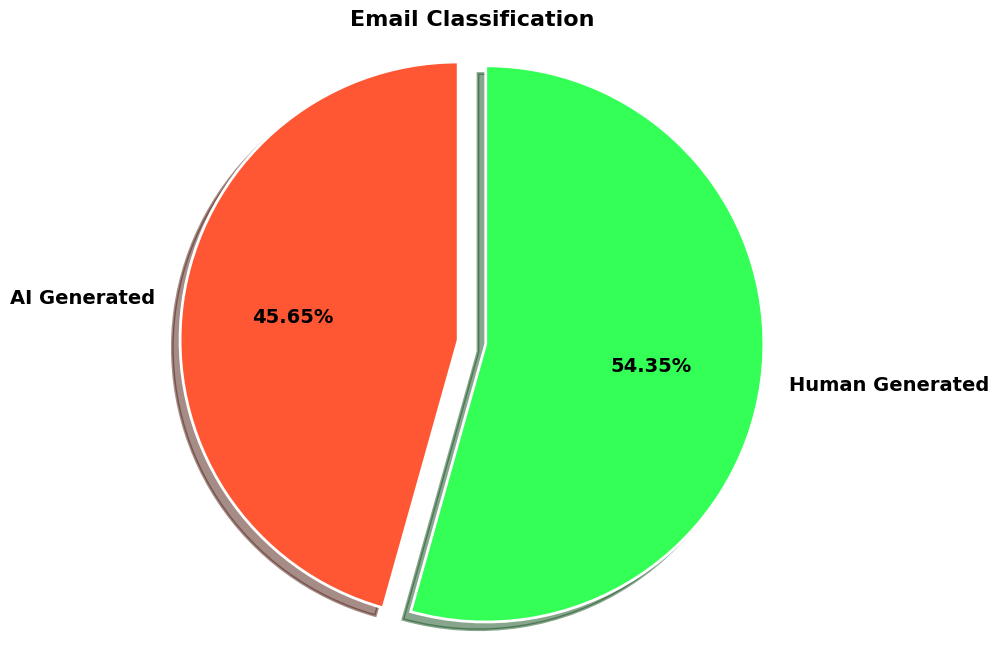

In [18]:
import matplotlib.pyplot as plt

# Sample data
# values = [75, 25]  # Example values for 'ham' and 'spam'

# Calculate the counts for each label (0 for AI, 1 for Human)
label_counts = df_combined['label'].value_counts()
values = [label_counts.get(0, 0), label_counts.get(1, 0)] # Get counts for label 0 and 1, default to 0 if not present

# Define custom colors
colors = ['#FF5733', '#33FF57']

# Define the explode parameter to create a gap between slices
explode = (0, 0.1)  # Explode the second slice (spam) by 10%

# Create a figure with a white background
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_facecolor('white')

# Create the pie chart with custom colors, labels, explode parameter, and shadow
wedges, texts, autotexts = ax.pie(
    values, labels=['AI Generated', 'Human Generated'], # Updated labels
    autopct='%0.2f%%',
    startangle=90,
    colors=colors,
    wedgeprops={'linewidth': 2, 'edgecolor': 'white'},
    explode=explode,  # Apply the explode parameter
    shadow=True  # Add shadow
)

# Customize text properties
for text, autotext in zip(texts, autotexts):
    text.set(size=14, weight='bold')
    autotext.set(size=14, weight='bold')

# Add a title
ax.set_title('Email Classification', fontsize=16, fontweight='bold')

# Equal aspect ratio ensures that pie is drawn as a circle
ax.axis('equal')

# Show the pie chart
plt.show()

# Importing Libraries, converting column values to string and counting characters of each row


In [19]:
# Ensure 'html_body' and suject are treated as string and handle potential NaNs
import nltk
nltk.download('punkt') # Download the 'punkt' tokenizer data
nltk.download('punkt_tab') # Download the 'punkt_tab' resource

df_combined['clean_body'] = df_combined['clean_body'].fillna('').astype(str)
df_combined['clean_subject'] = df_combined['clean_subject'].fillna('').astype(str)


# Add num_characters, num_words, and num_sentence columns for body
df_combined['body_num_characters'] = df_combined['clean_body'].apply(len)
df_combined['body_num_words'] = df_combined['clean_body'].apply(lambda x: len(word_tokenize(x)))
df_combined['body_num_sentence'] = df_combined['clean_body'].apply(lambda x: len(sent_tokenize(x)))

# Add num_characters, num_words, and num_sentences columns for subject
df_combined['subject_num_characters'] = df_combined['clean_subject'].apply(len)
df_combined['subject_num_words'] = df_combined['clean_subject'].apply(lambda x: len(word_tokenize(x)))
df_combined['subject_num_sentence'] = df_combined['clean_subject'].apply(lambda x: len(sent_tokenize(x)))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


# Displaying df_combined with  numerical columns

In [20]:
df_combined

,subject,html_body,label,clean_subject,clean_body,body_num_characters,body_num_words,body_num_sentence,subject_num_characters,subject_num_words,subject_num_sentence
0,Your Acme Cloud password reset request,"<!doctype html>\n<html>\n <body style=""font-f...",0,Your Acme Cloud password reset request,"Hi Alex, We noticed unusual activity on your E...",439,83,6,38,6,1
1,Lunch & Learn: Cyber Safety at Home,"<!doctype html>\n<html>\n <body style=""font-f...",0,Lunch & Learn: Cyber Safety at Home,"Hello Morgan, Thanks for being part of Fabrika...",285,56,4,35,8,1
2,Unusual sign-in activity detected from Chicago,"<!doctype html>\n<html>\n <body style=""font-f...",0,Unusual sign-in activity detected from Chicago,"Hi Riley, We noticed unusual activity on your ...",451,83,6,46,6,1
3,Welcome to Fabrikam Services! Getting started ...,"<!doctype html>\n<html>\n <body style=""font-f...",0,Welcome to Fabrikam Services! Getting started ...,"Hello Taylor, Thanks for being part of Fabrika...",285,56,4,51,8,2
4,Welcome to Tailspin Apps! Getting started guide,"<!doctype html>\n<html>\n <body style=""font-f...",0,Welcome to Tailspin Apps! Getting started guide,"Hello Alex, Thanks for being part of Northwind...",282,56,4,47,8,2
...,...,...,...,...,...,...,...,...,...,...,...
54762,confidence is back,"hello ,\r\nmy boyfriend began having problems ...",1,confidence is back,"hello , my boyfriend began having problems wit...",645,147,10,18,3,1
54763,important information,love - potion for your darling is all you want...,1,important information,love - potion for your darling is all you want...,272,57,8,21,2,1
54764,vys - make itnger,you have feelings of guilt and embarrassment ...,1,vys - make itnger,you have feelings of guilt and embarrassment h...,225,50,7,17,4,1
54765,the best thing come in large parcels,spur - m formula\r\nincrease sperm production ...,1,the best thing come in large parcels,spur - m formula increase sperm production 500...,399,78,6,36,7,1


# Summary Statistics for AI Generated Messages

In [21]:
# AI Generated
df_combined[df_combined['label'] == 0][['body_num_characters', 'body_num_words', 'body_num_sentence']].describe()

,body_num_characters,body_num_words,body_num_sentence
count,25000.000000,25000.000000,25000.00000
mean,363.007000,69.767160,5.00000
std,82.699831,13.648932,1.00002
min,275.000000,56.000000,4.00000
25%,280.000000,56.000000,4.00000
50%,359.500000,70.000000,5.00000
75%,446.000000,83.000000,6.00000
max,458.000000,85.000000,6.00000


# Summary Statistics for Human Messages

In [22]:
# Human Generated
df_combined[df_combined['label'] == 1][['body_num_characters', 'body_num_words', 'body_num_sentence']].describe()

,body_num_characters,body_num_words,body_num_sentence
count,29767.000000,29767.000000,29767.000000
mean,1464.121208,303.669097,18.510868
std,4165.842624,830.116072,56.595541
min,1.000000,1.000000,1.000000
25%,325.000000,67.000000,5.000000
50%,693.000000,150.000000,9.000000
75%,1539.000000,329.000000,19.000000
max,228352.000000,45450.000000,3094.000000


# Number of Characters of body

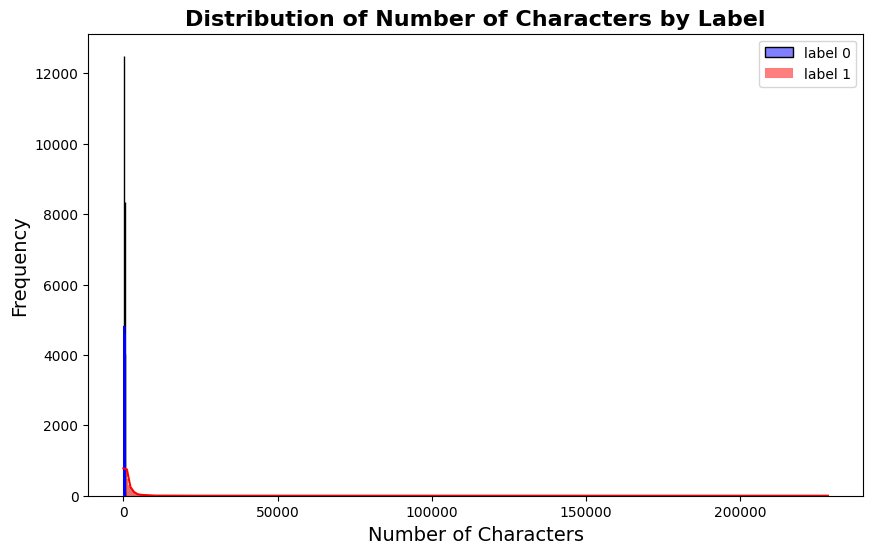

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a figure and set the figure size
plt.figure(figsize=(10, 6))

# Plot the histogram for label 0 in blue
sns.histplot(df_combined[df_combined['label'] == 0]['body_num_characters'], color='blue', label='label 0', kde=True)

# Plot the histogram for label 1 in red
sns.histplot(df_combined[df_combined['label'] == 1]['body_num_characters'], color='red', label='label 1', kde=True)

# Add labels and a title
plt.xlabel('Number of Characters', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title('Distribution of Number of Characters by Label', fontsize=16, fontweight='bold')

# Add a legend
plt.legend()

# Customize the appearance of the plot
sns.set(style='whitegrid')  # Add a white grid background

# Show the plot
plt.show()

# Number of Words of body

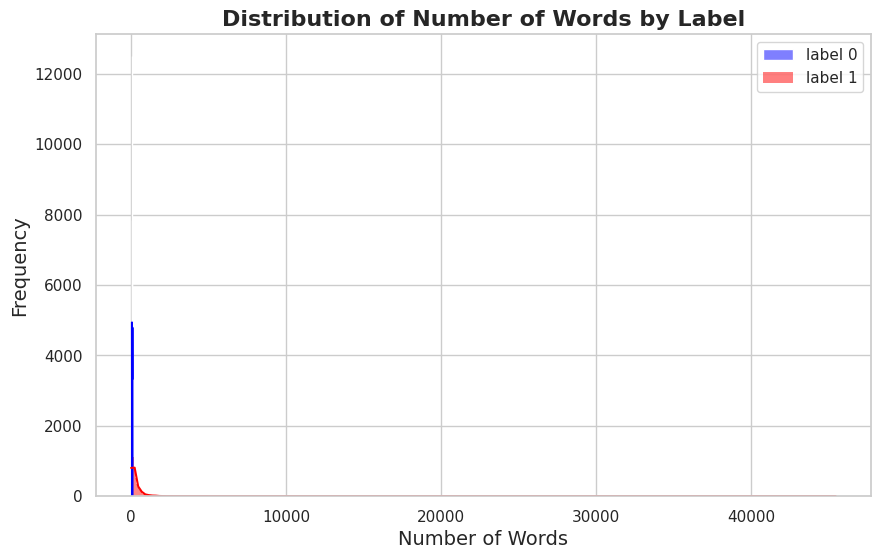

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a figure and set the figure size
plt.figure(figsize=(10, 6))

# Plot the histogram for label 0 in blue
sns.histplot(df_combined[df_combined['label'] == 0]['body_num_words'], color='blue', label='label 0', kde=True)

# Plot the histogram for label 1 in red
sns.histplot(df_combined[df_combined['label'] == 1]['body_num_words'], color='red', label='label 1', kde=True)

# Add labels and a title
plt.xlabel('Number of Words', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title('Distribution of Number of Words by Label', fontsize=16, fontweight='bold')

# Add a legend
plt.legend()

# Customize the appearance of the plot
sns.set(style='whitegrid')  # Add a white grid background

# Show the plot
plt.show()

# Correlation

In [25]:
df_combined[['label','body_num_characters', 'body_num_words', 'body_num_sentence']].corr()

,label,body_num_characters,body_num_words,body_num_sentence
label,1.000000,0.175776,0.186997,0.159216
body_num_characters,0.175776,1.000000,0.996285,0.826526
body_num_words,0.186997,0.996285,1.000000,0.848521
body_num_sentence,0.159216,0.826526,0.848521,1.000000


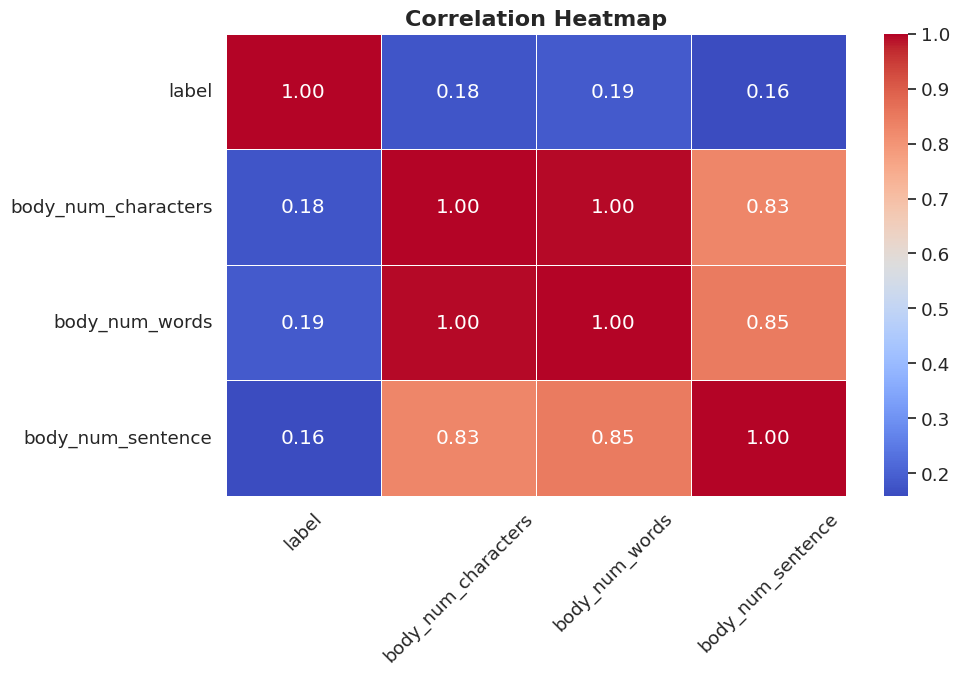

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select the columns for the correlation matrix
correlation_matrix = df_combined[['label', 'body_num_characters', 'body_num_words', 'body_num_sentence']].corr()

# Create a heatmap with custom styling
plt.figure(figsize=(10, 6))
sns.set(font_scale=1.2)  # Adjust font scale for better readability
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5, fmt=".2f")

# Set a title for the heatmap
plt.title("Correlation Heatmap", fontsize=16, fontweight='bold')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show the heatmap
plt.show()

# Combine subject + body into a single feature

In [27]:
# --- Data ---
# Ensuring both subject and body are strings
df = df_combined.copy()
df["label"] = df["label"].astype(int)
df["clean_subject"] = df["clean_subject"].astype(str)
df["clean_body"] = df["clean_body"].astype(str)

# Combine subject + body into a single feature
df['text'] = df['clean_subject'] + " " + df['clean_body']

# Displaying df to view combined columns "clean_subject"  + "clean_body"strip

In [28]:
df

,subject,html_body,label,clean_subject,clean_body,body_num_characters,body_num_words,body_num_sentence,subject_num_characters,subject_num_words,subject_num_sentence,text
0,Your Acme Cloud password reset request,"<!doctype html>\n<html>\n <body style=""font-f...",0,Your Acme Cloud password reset request,"Hi Alex, We noticed unusual activity on your E...",439,83,6,38,6,1,Your Acme Cloud password reset request Hi Alex...
1,Lunch & Learn: Cyber Safety at Home,"<!doctype html>\n<html>\n <body style=""font-f...",0,Lunch & Learn: Cyber Safety at Home,"Hello Morgan, Thanks for being part of Fabrika...",285,56,4,35,8,1,Lunch & Learn: Cyber Safety at Home Hello Morg...
2,Unusual sign-in activity detected from Chicago,"<!doctype html>\n<html>\n <body style=""font-f...",0,Unusual sign-in activity detected from Chicago,"Hi Riley, We noticed unusual activity on your ...",451,83,6,46,6,1,Unusual sign-in activity detected from Chicago...
3,Welcome to Fabrikam Services! Getting started ...,"<!doctype html>\n<html>\n <body style=""font-f...",0,Welcome to Fabrikam Services! Getting started ...,"Hello Taylor, Thanks for being part of Fabrika...",285,56,4,51,8,2,Welcome to Fabrikam Services! Getting started ...
4,Welcome to Tailspin Apps! Getting started guide,"<!doctype html>\n<html>\n <body style=""font-f...",0,Welcome to Tailspin Apps! Getting started guide,"Hello Alex, Thanks for being part of Northwind...",282,56,4,47,8,2,Welcome to Tailspin Apps! Getting started guid...
...,...,...,...,...,...,...,...,...,...,...,...,...
54762,confidence is back,"hello ,\r\nmy boyfriend began having problems ...",1,confidence is back,"hello , my boyfriend began having problems wit...",645,147,10,18,3,1,"confidence is back hello , my boyfriend began ..."
54763,important information,love - potion for your darling is all you want...,1,important information,love - potion for your darling is all you want...,272,57,8,21,2,1,important information love - potion for your d...
54764,vys - make itnger,you have feelings of guilt and embarrassment ...,1,vys - make itnger,you have feelings of guilt and embarrassment h...,225,50,7,17,4,1,vys - make itnger you have feelings of guilt a...
54765,the best thing come in large parcels,spur - m formula\r\nincrease sperm production ...,1,the best thing come in large parcels,spur - m formula increase sperm production 500...,399,78,6,36,7,1,the best thing come in large parcels spur - m ...


# Add num_characters, num_words, and num_sentences columns for text cloumn

In [29]:
# Add num_characters, num_words, and num_sentences columns for text
df['text_num_characters'] = df['text'].apply(len)
df['text_num_words'] = df['text'].apply(lambda x: len(word_tokenize(x)))
df['text_num_sentence'] = df['text'].apply(lambda x: len(sent_tokenize(x)))

# Display df

In [30]:
df.head(5)

,subject,html_body,label,clean_subject,clean_body,body_num_characters,body_num_words,body_num_sentence,subject_num_characters,subject_num_words,subject_num_sentence,text,text_num_characters,text_num_words,text_num_sentence
0,Your Acme Cloud password reset request,"<!doctype html>\n<html>\n <body style=""font-f...",0,Your Acme Cloud password reset request,"Hi Alex, We noticed unusual activity on your E...",439,83,6,38,6,1,Your Acme Cloud password reset request Hi Alex...,478,89,6
1,Lunch & Learn: Cyber Safety at Home,"<!doctype html>\n<html>\n <body style=""font-f...",0,Lunch & Learn: Cyber Safety at Home,"Hello Morgan, Thanks for being part of Fabrika...",285,56,4,35,8,1,Lunch & Learn: Cyber Safety at Home Hello Morg...,321,64,4
2,Unusual sign-in activity detected from Chicago,"<!doctype html>\n<html>\n <body style=""font-f...",0,Unusual sign-in activity detected from Chicago,"Hi Riley, We noticed unusual activity on your ...",451,83,6,46,6,1,Unusual sign-in activity detected from Chicago...,498,89,6
3,Welcome to Fabrikam Services! Getting started ...,"<!doctype html>\n<html>\n <body style=""font-f...",0,Welcome to Fabrikam Services! Getting started ...,"Hello Taylor, Thanks for being part of Fabrika...",285,56,4,51,8,2,Welcome to Fabrikam Services! Getting started ...,337,64,5
4,Welcome to Tailspin Apps! Getting started guide,"<!doctype html>\n<html>\n <body style=""font-f...",0,Welcome to Tailspin Apps! Getting started guide,"Hello Alex, Thanks for being part of Northwind...",282,56,4,47,8,2,Welcome to Tailspin Apps! Getting started guid...,330,64,5


In [31]:
df[['label','text_num_characters', 'text_num_words', 'text_num_sentence']].corr()

,label,text_num_characters,text_num_words,text_num_sentence
label,1.000000,0.175372,0.187857,0.163124
text_num_characters,0.175372,1.000000,0.996242,0.825686
text_num_words,0.187857,0.996242,1.000000,0.847779
text_num_sentence,0.163124,0.825686,0.847779,1.000000


# Displaying a Correlation Map of Numrical rows

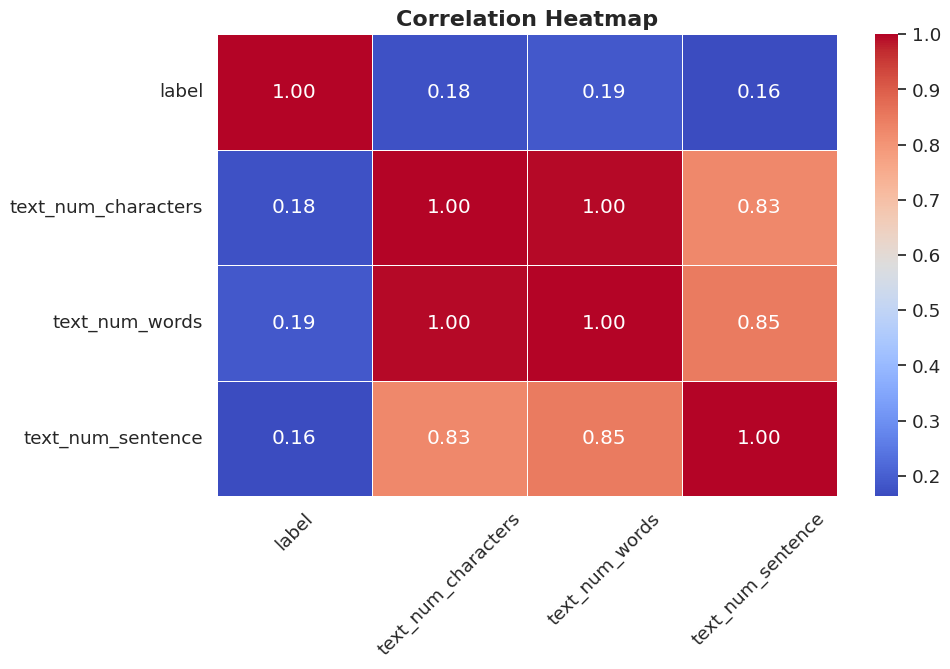

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select the columns for the correlation matrix
correlation_matrix = df[['label', 'text_num_characters', 'text_num_words', 'text_num_sentence']].corr()

# Create a heatmap with custom styling
plt.figure(figsize=(10, 6))
sns.set(font_scale=1.2)  # Adjust font scale for better readability
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5, fmt=".2f")

# Set a title for the heatmap
plt.title("Correlation Heatmap", fontsize=16, fontweight='bold')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show the heatmap
plt.show()

# Displaying a Fequency Distribution of data

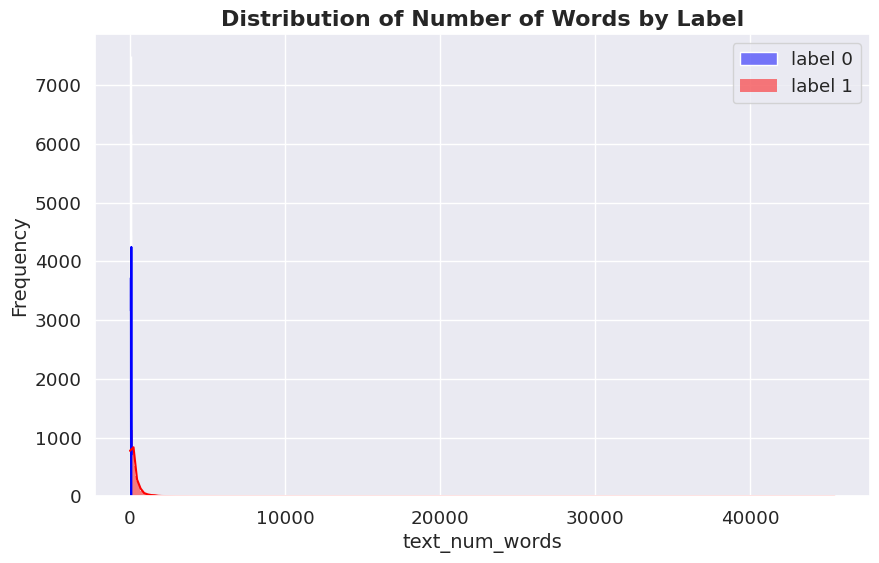

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a figure and set the figure size
plt.figure(figsize=(10, 6))

# Plot the histogram for label 0 in blue
sns.histplot(df[df['label'] == 0]['text_num_words'], color='blue', label='label 0', kde=True)

# Plot the histogram for label 1 in red
sns.histplot(df[df['label'] == 1]['text_num_words'], color='red', label='label 1', kde=True)

# Add labels and a title
plt.xlabel('text_num_words', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title('Distribution of Number of Words by Label', fontsize=16, fontweight='bold')

# Add a legend
plt.legend()

# Customize the appearance of the plot
sns.set(style='whitegrid')  # Add a white grid background

# Show the plot
plt.show()

# Data Preprocessing

In [34]:
# Importing the Porter Stemmer for text stemming
from nltk.stem.porter import PorterStemmer
# Importing stopwords
from nltk.corpus import stopwords
# Importing the string module for handling special characters
import string
import nltk

# Download stopwords if not already downloaded
nltk.download('stopwords')

# Creating an instance of the Porter Stemmer
ps = PorterStemmer()

# Lowercase transformation and text preprocessing function
def transform_text(text):
    # Transform the text to lowercase
    text = text.lower()

    # Tokenization using NLTK
    text = nltk.word_tokenize(text)

    # Removing special characters
    y = []
    for i in text:
        if i.isalnum():
            y.append(i)

    # Removing stop words and punctuation
    text = y[:]
    y.clear()

    # Loop through the tokens and remove stopwords and punctuation
    for i in text:
        if i not in stopwords.words('english') and i not in string.punctuation:
            y.append(i)

    # Stemming using Porter Stemmer
    text = y[:]
    y.clear()
    for i in text:
        y.append(ps.stem(i))

    # Join the processed tokens back into a single string
    return " ".join(y)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Displaying a sample of a message that can be transformed

In [35]:
transform_text('We must do our best to make the CYBER Space Safe. Threat actors continue to evolve their tactics')

'must best make cyber space safe threat actor continu evolv tactic'

# Transforming text column to remove stop words (very common, high-frequency words that are often filtered out in text analysis and Natural Language Processing (NLP) because they are considered to have little to no semantic meaning)

In [36]:
df['text'] = df['text'].apply(transform_text)

# Displaying cleaned df_comibined

In [37]:
df.head(5)

,subject,html_body,label,clean_subject,clean_body,body_num_characters,body_num_words,body_num_sentence,subject_num_characters,subject_num_words,subject_num_sentence,text,text_num_characters,text_num_words,text_num_sentence
0,Your Acme Cloud password reset request,"<!doctype html>\n<html>\n <body style=""font-f...",0,Your Acme Cloud password reset request,"Hi Alex, We noticed unusual activity on your E...",439,83,6,38,6,1,acm cloud password reset request hi alex notic...,478,89,6
1,Lunch & Learn: Cyber Safety at Home,"<!doctype html>\n<html>\n <body style=""font-f...",0,Lunch & Learn: Cyber Safety at Home,"Hello Morgan, Thanks for being part of Fabrika...",285,56,4,35,8,1,lunch learn cyber safeti home hello morgan tha...,321,64,4
2,Unusual sign-in activity detected from Chicago,"<!doctype html>\n<html>\n <body style=""font-f...",0,Unusual sign-in activity detected from Chicago,"Hi Riley, We noticed unusual activity on your ...",451,83,6,46,6,1,unusu activ detect chicago hi riley notic unus...,498,89,6
3,Welcome to Fabrikam Services! Getting started ...,"<!doctype html>\n<html>\n <body style=""font-f...",0,Welcome to Fabrikam Services! Getting started ...,"Hello Taylor, Thanks for being part of Fabrika...",285,56,4,51,8,2,welcom fabrikam servic get start guid hello ta...,337,64,5
4,Welcome to Tailspin Apps! Getting started guide,"<!doctype html>\n<html>\n <body style=""font-f...",0,Welcome to Tailspin Apps! Getting started guide,"Hello Alex, Thanks for being part of Northwind...",282,56,4,47,8,2,welcom tailspin app get start guid hello alex ...,330,64,5


# Saving Output of data as "stemmed_email_dataset.csv"

In [38]:
output_path = "stemmed_email_dataset.csv"
df.to_csv(output_path, index=False)

print(f"Stemmed dataset saved: {output_path}")
print(f"Shape: {df.shape}")
print("Columns:", df.columns.tolist())

Stemmed dataset saved: stemmed_email_dataset.csv
Shape: (54767, 15)
Columns: ['subject', 'html_body', 'label', 'clean_subject', 'clean_body', 'body_num_characters', 'body_num_words', 'body_num_sentence', 'subject_num_characters', 'subject_num_words', 'subject_num_sentence', 'text', 'text_num_characters', 'text_num_words', 'text_num_sentence']


# Importing word cloud and displaying text column words for AI Genarated and Human Generated

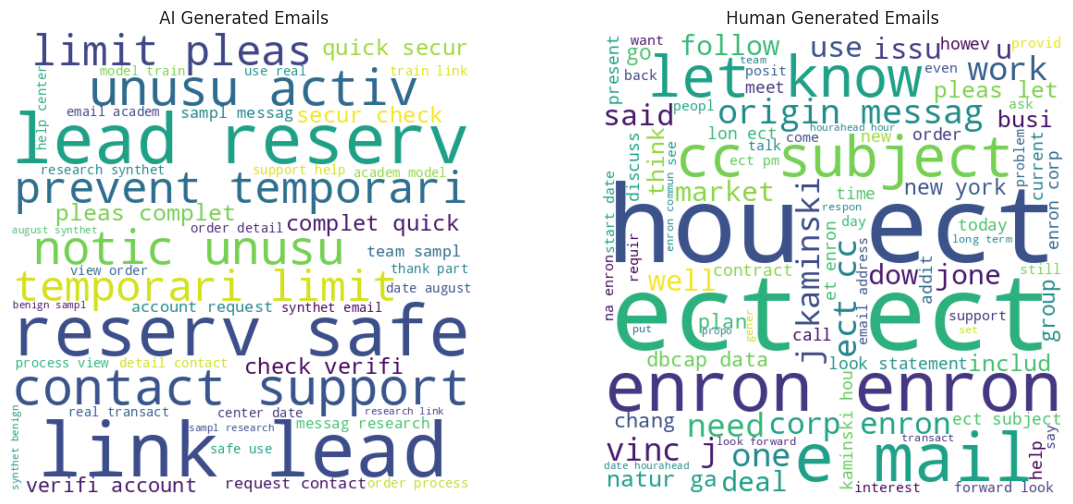

In [39]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt # Import matplotlib.pyplot

# Plot AI Generated Emails and Human Generetaed Emails side by side
plt.figure(figsize=(14,6))


wc = WordCloud(width = 500, height = 500, min_font_size = 10, background_color = 'white')
ai_wc = wc.generate(df[df['label'] == 0]['text'].str.cat(sep = " "))

wc = WordCloud(width = 500, height = 500, min_font_size = 10, background_color = 'white')
human_wc = wc.generate(df[df['label'] == 1]['text'].str.cat(sep = " "))

# Robot word cloud
plt.subplot(1, 2, 1)
plt.imshow(ai_wc, interpolation="bilinear")
plt.axis("off")
plt.title(" AI Generated Emails")

# Human word cloud
plt.subplot(1, 2, 2)
plt.imshow(human_wc, interpolation="bilinear")
plt.axis("off")
plt.title("Human Generated Emails")

plt.show()

# Displaying top 25 words in clean_body column (human generated email)

In [40]:
import seaborn as sns
spam_carpos = []
for sentence in df[df['label'] == 1]['clean_body'].tolist():
    for word in sentence.split():
        spam_carpos.append(word)

In [41]:
from collections import Counter
filter_df = pd.DataFrame(Counter(spam_carpos).most_common(25))

/tmp/ipython-input-2512895475.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data = filter_df, x = filter_df[0], y = filter_df[1], palette = 'bright')


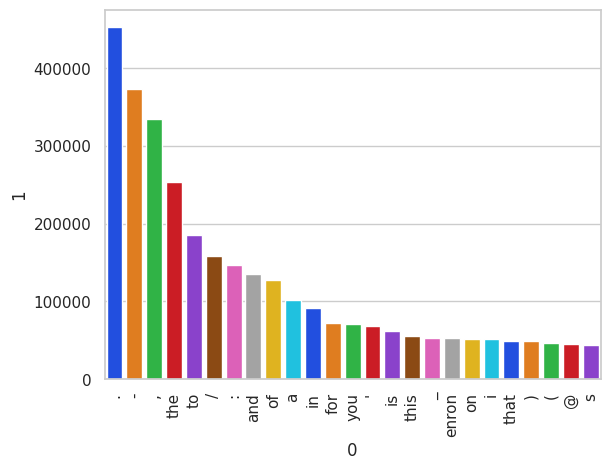

In [42]:
sns.barplot(data = filter_df, x = filter_df[0], y = filter_df[1], palette = 'bright')
plt.xticks(rotation = 90)
plt.show()

# Displaying top 25 words in clean_body column (AI_generated email)

In [43]:
spam_carpos = []
for sentence in df[df['label'] == 0]['clean_body'].tolist():
    for word in sentence.split():
        spam_carpos.append(word)

In [44]:
from collections import Counter
filter_df = pd.DataFrame(Counter(spam_carpos).most_common(25))

/tmp/ipython-input-1163994054.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data = filter_df, x = filter_df[0], y = filter_df[1], palette = 'cool')


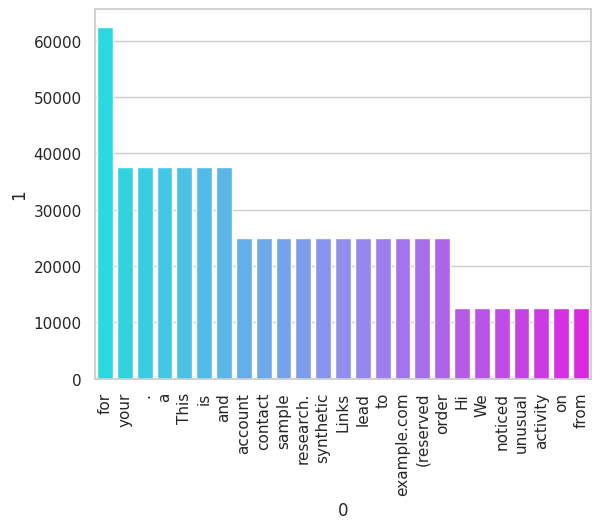

In [45]:
sns.barplot(data = filter_df, x = filter_df[0], y = filter_df[1], palette = 'cool')
plt.xticks(rotation = 90)
plt.show()

# Importing word cloud and displaying clean_subject column words for AI Genarated and Human Generated

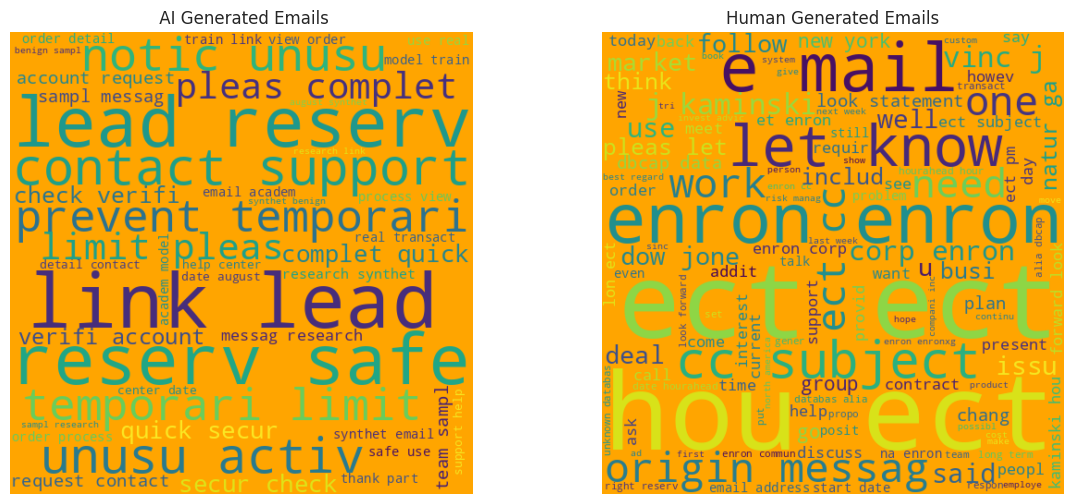

In [46]:

# Plot AI Generated Emails and Human Generetaed Emails side by side
plt.figure(figsize=(14,6))


wc = WordCloud(width = 500, height = 500, min_font_size = 10, background_color = 'orange')
ai_wc = wc.generate(df[df['label'] == 0]['text'].str.cat(sep = " "))

wc = WordCloud(width = 500, height = 500, min_font_size = 10, background_color = 'orange')
human_wc = wc.generate(df[df['label'] == 1]['text'].str.cat(sep = " "))

# Robot word cloud
plt.subplot(1, 2, 1)
plt.imshow(ai_wc, interpolation="bilinear")
plt.axis("off")
plt.title(" AI Generated Emails")

# Human word cloud
plt.subplot(1, 2, 2)
plt.imshow(human_wc, interpolation="bilinear")
plt.axis("off")
plt.title("Human Generated Emails")

plt.show()

# Show top 25 words in clean_subject column (Human Generated Email)

In [47]:
spam_carpos = []
for sentence in df[df['label'] == 1]['clean_subject'].tolist():
    for word in sentence.split():
        spam_carpos.append(word)

In [48]:
from collections import Counter
filter_df = pd.DataFrame(Counter(spam_carpos).most_common(25))

/tmp/ipython-input-2512895475.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data = filter_df, x = filter_df[0], y = filter_df[1], palette = 'bright')


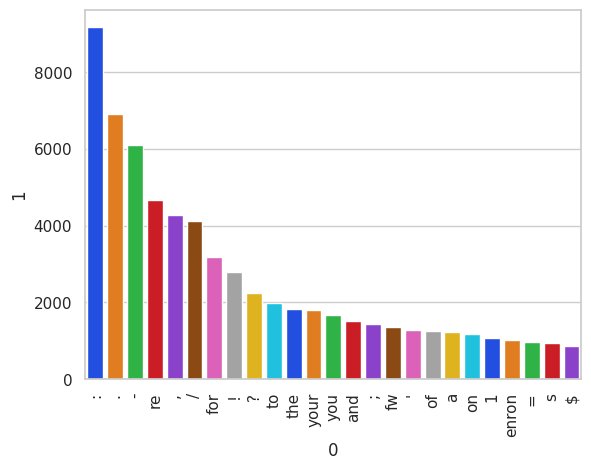

In [49]:
sns.barplot(data = filter_df, x = filter_df[0], y = filter_df[1], palette = 'bright')
plt.xticks(rotation = 90)
plt.show()

# Show top 25 words in clean_subject column (AI Generated Email)

In [50]:
spam_carpos = []
for sentence in df[df['label'] == 0]['clean_subject'].tolist():
    for word in sentence.split():
        spam_carpos.append(word)

In [51]:
from collections import Counter
filter_df = pd.DataFrame(Counter(spam_carpos).most_common(25))

/tmp/ipython-input-1163994054.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data = filter_df, x = filter_df[0], y = filter_df[1], palette = 'cool')


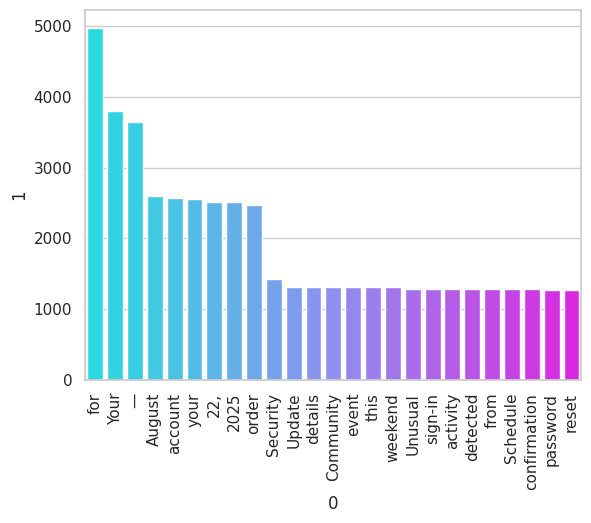

In [52]:
sns.barplot(data = filter_df, x = filter_df[0], y = filter_df[1], palette = 'cool')
plt.xticks(rotation = 90)
plt.show()

# Importing Libraries for Models for training and testing

In [53]:
# Importing Libraries
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, confusion_matrix,
                             ConfusionMatrixDisplay)

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier,
                              BaggingClassifier, ExtraTreesClassifier,
                              GradientBoostingClassifier)
from xgboost import XGBClassifier
import matplotlib.pyplot as plt

 #  Startifying data with Dependent and Independent Variable

In [54]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
tfid = TfidfVectorizer(max_features=3000)

# Combine numerical features with the vectorized text data
numerical_features = ['body_num_characters', 'body_num_words', 'body_num_sentence',
                      'subject_num_characters', 'subject_num_words', 'subject_num_sentence',
                      'text_num_characters', 'text_num_words', 'text_num_sentence']

X_numerical = df[numerical_features].values
X_text = tfid.fit_transform(df["text"]).toarray() # Re-vectorize the full text data

# Combine text features and numerical features
X_combined = np.hstack((X_text, X_numerical))
y = df["label"].values

# Stratified split
from sklearn.model_selection import train_test_split
X_train, X_test , y_train, y_test = train_test_split(X_combined, y, test_size = 0.20, random_state = 2, stratify=y)

# Importing Models

In [55]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier

# Initializing Models

In [56]:
# Dictionary of classifiers
from sklearn.svm import LinearSVC
Linearsvc = LinearSVC(random_state=42) # Replaced SVC with LinearSVC
knc = KNeighborsClassifier()
dtc = DecisionTreeClassifier(max_depth=5)
lrc = LogisticRegression(solver='liblinear', penalty='l1')
rfc = RandomForestClassifier(n_estimators=50, random_state=2)
abc = AdaBoostClassifier(n_estimators=50, random_state=2)
bc = BaggingClassifier(n_estimators=50, random_state=2)
etc = ExtraTreesClassifier(n_estimators=50, random_state=2)
gbdt = GradientBoostingClassifier(n_estimators=50, random_state=2)
xgb = XGBClassifier(n_estimators=50, random_state=2)

# Dictionary to be used for the Models

In [57]:
from sklearn.svm import LinearSVC
# Dictionary of classifiers
clfs = {'LinearSVC': LinearSVC(random_state=42), 'KNN': knc, 'DT': dtc, 'LR': lrc, 'RF': rfc, 'Adaboost': abc, 'Bgc': bc, 'ETC': etc, 'GBDT': gbdt, 'xgb': xgb}

# Training Models

In [58]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import numpy as np

def train_classifier(clf, X_train, y_train, X_test, y_test):

    # Fit the classifier
    clf.fit(X_train, y_train)

    # Get predictions
    y_pred = clf.predict(X_test)

    # Get predicted probabilities for ROC-AUC
    # This needs to be handled differently for classifiers without predict_proba
    if hasattr(clf, "predict_proba"):
        y_pred_proba = clf.predict_proba(X_test)[:, 1]
    elif hasattr(clf, "decision_function"):
         # For models with decision_function but not predict_proba (like some SVCs)
         y_pred_proba = clf.decision_function(X_test)
         # Note: decision_function output might need scaling for meaningful probabilities,
         # but for basic AUC calculation, the relative order of scores is often sufficient.
    else:
        # Handle classifiers that don't have predict_proba or decision_function
        # For binary classification, this might mean returning prediction scores if available
        # or simply noting that AUC cannot be calculated with probabilities.
        # For now, return NaN for AUC if probabilities are not available.
        y_pred_proba = np.nan # Placeholder if neither method is available


    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average="weighted", zero_division=0)
    recall = recall_score(y_test, y_pred, average="weighted", zero_division=0)
    f1 = f1_score(y_test, y_pred, average="weighted", zero_division=0)

    # Calculate ROC AUC only if y_pred_proba is not NaN and contains valid values
    if np.isnan(y_pred_proba).any() or len(np.unique(y_test)) < 2:
         roc = np.nan # Cannot compute AUC if no probabilities or only one class in y_test
    else:
         roc = roc_auc_score(y_test, y_pred_proba)


    # Return all necessary values, including y_pred for the confusion matrix
    return accuracy, precision, recall, f1, roc, y_pred

# Evaluate the performance of each optimized model on the test set

Starting training for LinearSVC...
Finished training for LinearSVC.

Evaluation results for LinearSVC:
Accuracy: 0.9999
Precision: 0.9999
Recall: 0.9999
F1-score: 0.9999
ROC AUC: 0.9998


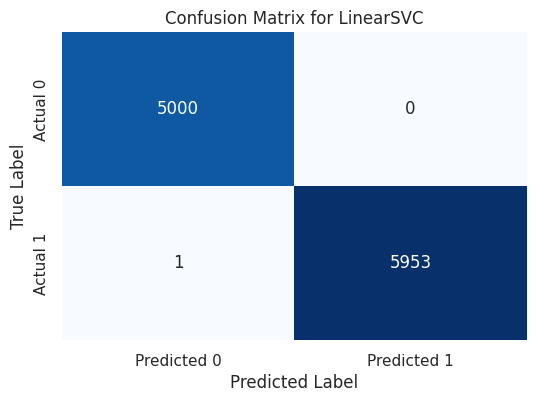

Starting training for KNN...
Finished training for KNN.

Evaluation results for KNN:
Accuracy: 0.9972
Precision: 0.9972
Recall: 0.9972
F1-score: 0.9972
ROC AUC: 0.9986


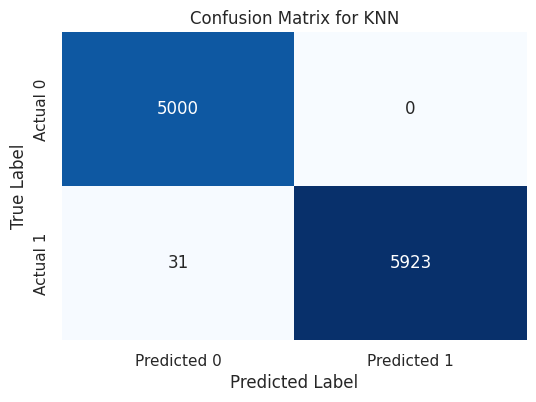

Starting training for DT...
Finished training for DT.

Evaluation results for DT:
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1-score: 1.0000
ROC AUC: 1.0000


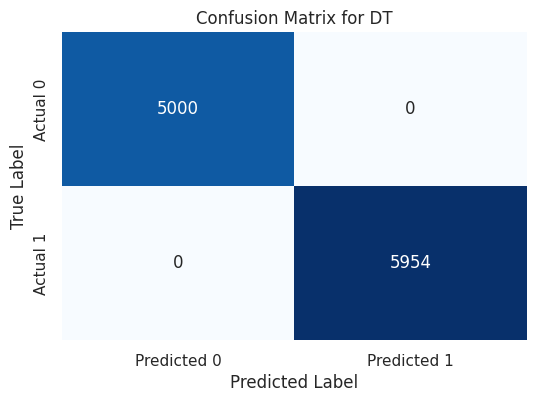

Starting training for LR...
Finished training for LR.


/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(



Evaluation results for LR:
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1-score: 1.0000
ROC AUC: 1.0000


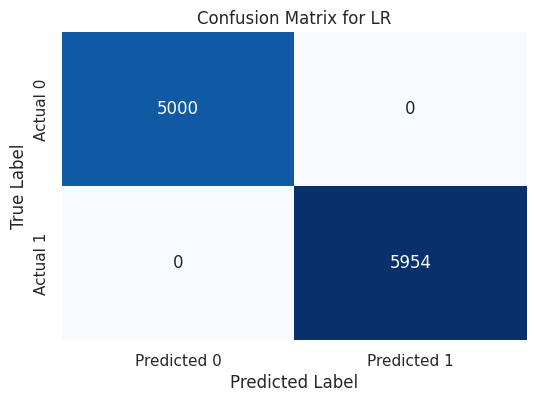

Starting training for RF...
Finished training for RF.

Evaluation results for RF:
Accuracy: 0.9999
Precision: 0.9999
Recall: 0.9999
F1-score: 0.9999
ROC AUC: 1.0000


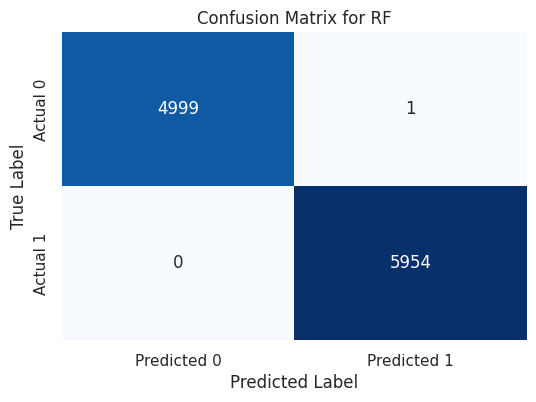

Starting training for Adaboost...
Finished training for Adaboost.

Evaluation results for Adaboost:
Accuracy: 0.9999
Precision: 0.9999
Recall: 0.9999
F1-score: 0.9999
ROC AUC: 1.0000


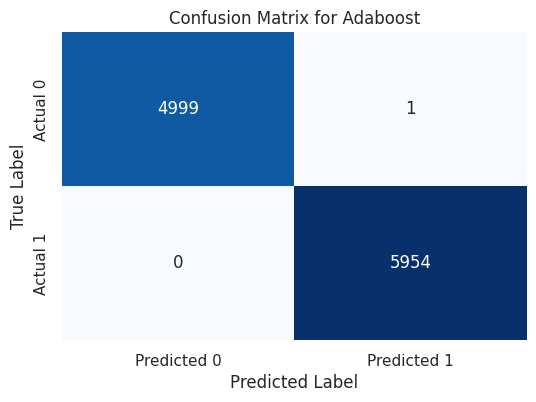

Starting training for Bgc...
Finished training for Bgc.

Evaluation results for Bgc:
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1-score: 1.0000
ROC AUC: 1.0000


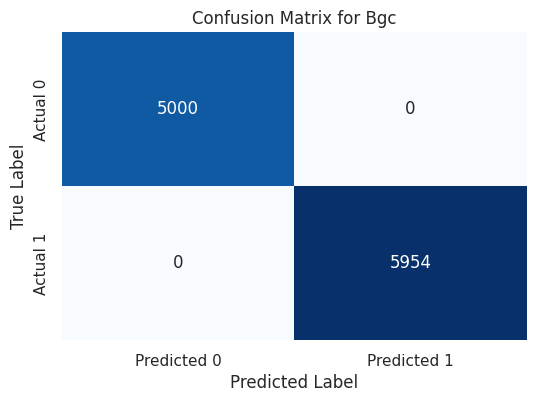

Starting training for ETC...
Finished training for ETC.

Evaluation results for ETC:
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1-score: 1.0000
ROC AUC: 1.0000


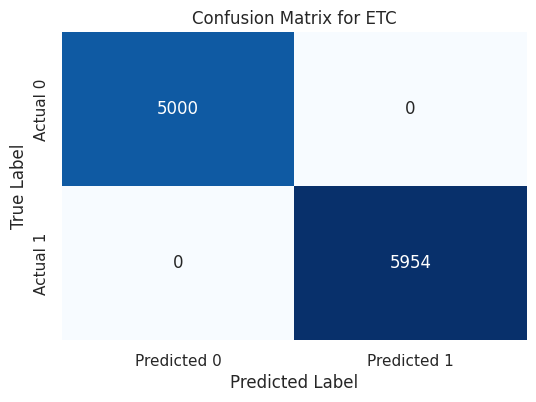

Starting training for GBDT...
Finished training for GBDT.

Evaluation results for GBDT:
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1-score: 1.0000
ROC AUC: 1.0000


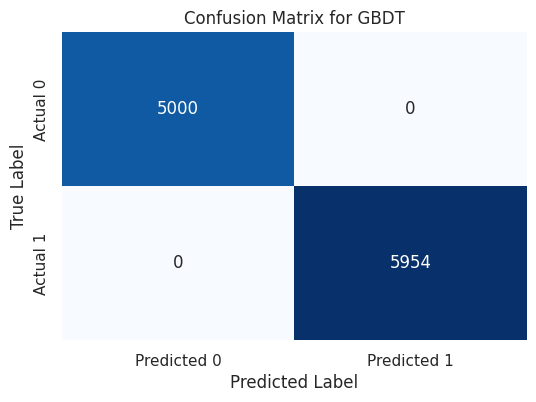

Starting training for xgb...
Finished training for xgb.

Evaluation results for xgb:
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1-score: 1.0000
ROC AUC: 1.0000


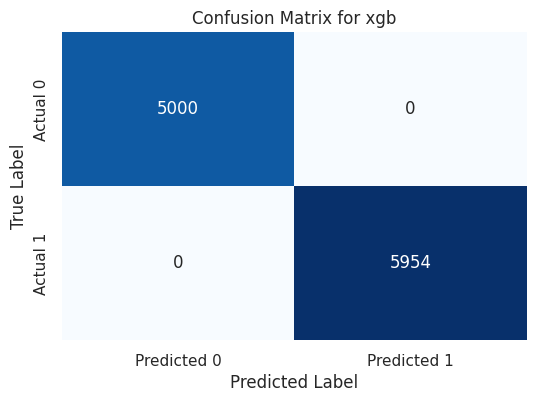

In [59]:
for model_name, model in clfs.items():
    print(f"Starting training for {model_name}...")
    # ... your existing code
    print(f"Finished training for {model_name}.")
    # Remove SVC for the fast run
    clfs_fast = {k: v for k, v in clfs.items() if k != 'SVC'}
    # Call the train_classifier function and unpack the returned values
    accuracy, precision, recall, f1, roc, y_pred = train_classifier(model, X_train, y_train, X_test, y_test)

    # Print the results for each model
    print(f"\nEvaluation results for {model_name}:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")
    print(f"ROC AUC: {roc:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=['Predicted 0', 'Predicted 1'],
                yticklabels=['Actual 0', 'Actual 1'])
    plt.title(f'Confusion Matrix for {model_name}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

# Cross Validating Models

In [60]:
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import numpy as np
from sklearn.svm import SVC, LinearSVC # Import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.datasets import make_classification

X, y = make_classification(n_samples=1000, n_features=20, n_informative=10,
                           n_redundant=5, random_state=42)

# Classifiers
clfs = {
    'LinearSVC': LinearSVC(random_state=42), # Replaced SVC with LinearSVC
    'KNN': KNeighborsClassifier(),
    'DT': DecisionTreeClassifier(max_depth=5),
    'LR': LogisticRegression(solver='liblinear', penalty='l1'),
    'RF': RandomForestClassifier(n_estimators=20, random_state=2),
    'Adaboost': AdaBoostClassifier(n_estimators=20, random_state=2),
    'Bgc': BaggingClassifier(n_estimators=20, random_state=2),
    'ETC': ExtraTreesClassifier(n_estimators=20, random_state=2),
    'GBDT': GradientBoostingClassifier(n_estimators=20, random_state=2),
    'xgb': XGBClassifier(n_estimators=20, random_state=2)
}

# Cross-validation strategy
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Metrics
scoring = ['accuracy','precision_weighted','recall_weighted','f1_weighted','roc_auc']

# Results dictionary
results = {}

for model_name, model in clfs.items():
    print(f"\nPerforming cross-validation for {model_name}...")
    pipeline = make_pipeline(StandardScaler(), model)

    cv_results = cross_validate(pipeline, X, y, cv=cv_strategy,
                                scoring=scoring, return_train_score=True)

    # Store raw values
    results[model_name] = {
        'train_accuracy_mean': cv_results['train_accuracy'].mean(),
        'test_accuracy_mean': cv_results['test_accuracy'].mean(),
        'train_f1_mean': cv_results['train_f1_weighted'].mean(),
        'test_f1_mean': cv_results['test_f1_weighted'].mean(),
        'train_roc_auc_mean': cv_results['train_roc_auc'].mean(),
        'test_roc_auc_mean': cv_results['test_roc_auc'].mean(),
        'fit_time_mean': cv_results['fit_time'].mean(),
        'score_time_mean': cv_results['score_time'].mean()
    }

    # Overfitting gap
    acc_gap = results[model_name]['train_accuracy_mean'] - results[model_name]['test_accuracy_mean']
    f1_gap = results[model_name]['train_f1_mean'] - results[model_name]['test_f1_mean']
    auc_gap = results[model_name]['train_roc_auc_mean'] - results[model_name]['test_roc_auc_mean']
    overfit_penalty = (abs(acc_gap) + abs(f1_gap) + abs(auc_gap)) / 3

    # Composite score = performance – penalty
    alpha = 0.5  # how strongly to penalize overfitting
    final_score = results[model_name]['test_f1_mean'] - alpha * overfit_penalty
    results[model_name]['final_score'] = final_score
    results[model_name]['overfit_penalty'] = overfit_penalty

    print(f"Train Acc: {results[model_name]['train_accuracy_mean']:.4f} | Test Acc: {results[model_name]['test_accuracy_mean']:.4f} (gap {acc_gap:.4f})")
    print(f"Train F1: {results[model_name]['train_f1_mean']:.4f} | Test F1: {results[model_name]['test_f1_mean']:.4f} (gap {f1_gap:.4f})")
    print(f"Train AUC: {results[model_name]['train_roc_auc_mean']:.4f} | Test AUC: {results[model_name]['test_roc_auc_mean']:.4f} (gap {auc_gap:.4f})")
    print(f"Final Score (penalized): {final_score:.4f}")

# ---- Ranking Models ----
print("\n--- Model Ranking (by penalized score) ---")
ranked = sorted(results.items(), key=lambda x: x[1]['final_score'], reverse=True)
for rank, (model_name, metrics) in enumerate(ranked, 1):
    print(f"{rank}. {model_name} | Final Score: {metrics['final_score']:.4f} | Test F1: {metrics['test_f1_mean']:.4f} | Overfit Penalty: {metrics['overfit_penalty']:.4f}")


Performing cross-validation for LinearSVC...
Train Acc: 0.8475 | Test Acc: 0.8410 (gap 0.0065)
Train F1: 0.8474 | Test F1: 0.8409 (gap 0.0066)
Train AUC: 0.9201 | Test AUC: 0.9128 (gap 0.0073)
Final Score (penalized): 0.8375

Performing cross-validation for KNN...
Train Acc: 0.9572 | Test Acc: 0.9220 (gap 0.0353)
Train F1: 0.9572 | Test F1: 0.9220 (gap 0.0353)
Train AUC: 0.9912 | Test AUC: 0.9680 (gap 0.0232)
Final Score (penalized): 0.9064

Performing cross-validation for DT...
Train Acc: 0.9123 | Test Acc: 0.8360 (gap 0.0763)
Train F1: 0.9122 | Test F1: 0.8358 (gap 0.0764)
Train AUC: 0.9566 | Test AUC: 0.8532 (gap 0.1033)
Final Score (penalized): 0.7932

Performing cross-validation for LR...
Train Acc: 0.8487 | Test Acc: 0.8450 (gap 0.0037)
Train F1: 0.8487 | Test F1: 0.8449 (gap 0.0038)
Train AUC: 0.9201 | Test AUC: 0.9127 (gap 0.0075)
Final Score (penalized): 0.8424

Performing cross-validation for RF...
Train Acc: 0.9992 | Test Acc: 0.9210 (gap 0.0783)
Train F1: 0.9993 | Test F1:

# visualization of models performance

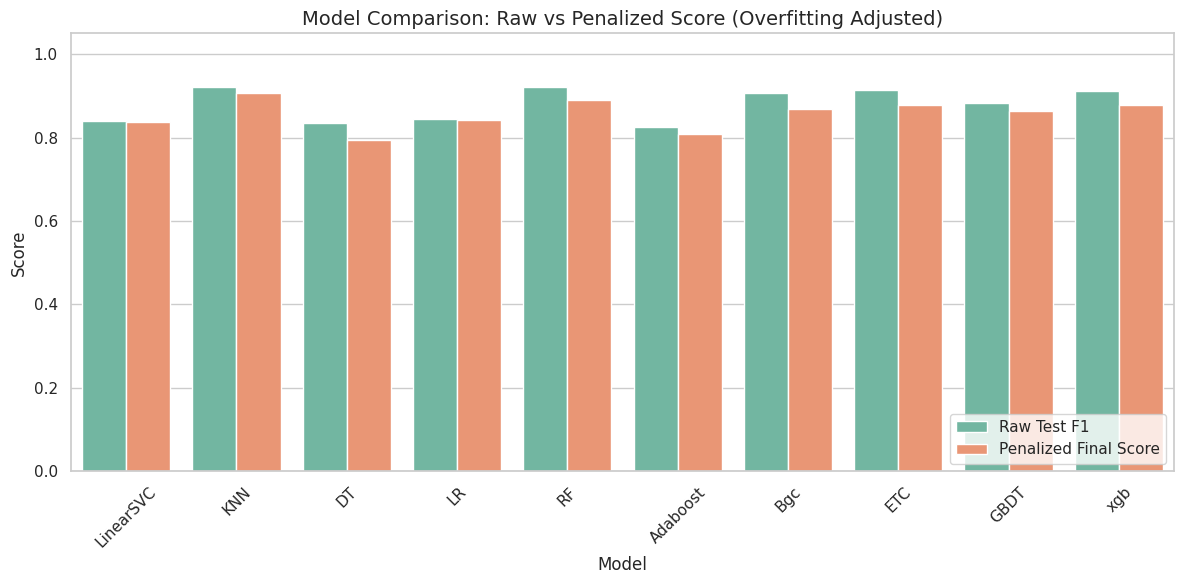

In [61]:

# ---- Visualization ----
# Prepare data for plotting
plot_data = []
for model_name, metrics in results.items():
    plot_data.append({"Model": model_name, "Score": metrics['test_f1_mean'], "Type": "Raw Test F1"})
    plot_data.append({"Model": model_name, "Score": metrics['final_score'], "Type": "Penalized Final Score"})

plot_df = sns.load_dataset("tips")
import pandas as pd
plot_df = pd.DataFrame(plot_data)

plt.figure(figsize=(12, 6))
sns.barplot(x="Model", y="Score", hue="Type", data=plot_df, palette="Set2")
plt.title("Model Comparison: Raw vs Penalized Score (Overfitting Adjusted)", fontsize=14)
plt.xticks(rotation=45)
plt.ylabel("Score")
plt.ylim(0, 1.05)
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

# Download text (contains clean_body + clean_subject data)

In [62]:
output_path = "cleantext_email_dataset.csv"
df.to_csv(output_path, index=False)

print(f"clean text dataset saved: {output_path}")
print(f"Shape: {df.shape}")
print("Columns:", df.columns.tolist())

clean text dataset saved: cleantext_email_dataset.csv
Shape: (54767, 15)
Columns: ['subject', 'html_body', 'label', 'clean_subject', 'clean_body', 'body_num_characters', 'body_num_words', 'body_num_sentence', 'subject_num_characters', 'subject_num_words', 'subject_num_sentence', 'text', 'text_num_characters', 'text_num_words', 'text_num_sentence']


# Hypothesis Testing


=== Model Performance on Single Train-Test Split ===

Evaluating SVC...
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1-score: 1.0000
ROC AUC: 1.0000


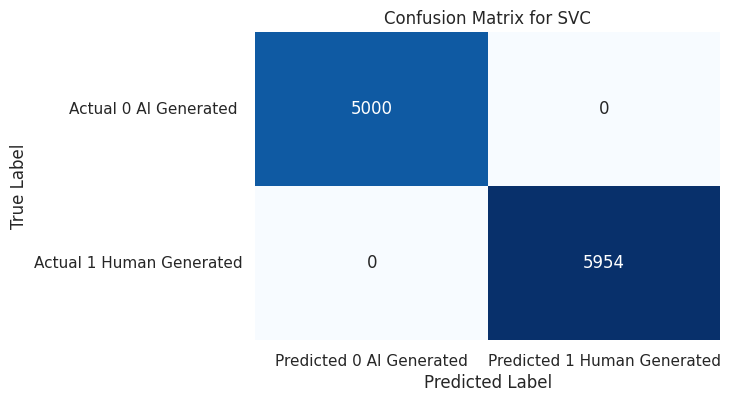


Evaluating KNN...
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1-score: 1.0000
ROC AUC: 1.0000


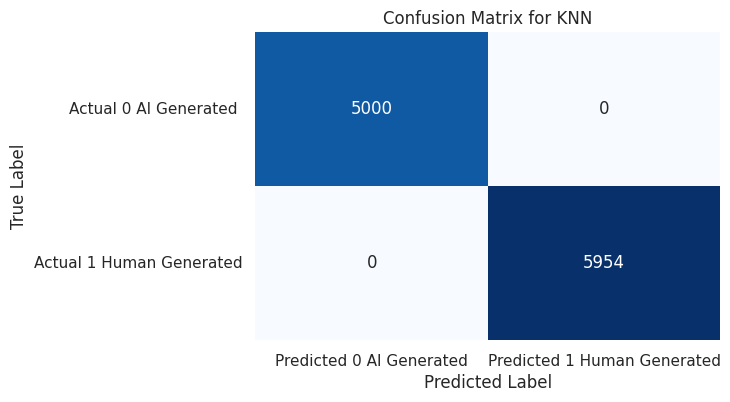


Evaluating DT...
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1-score: 1.0000
ROC AUC: 1.0000


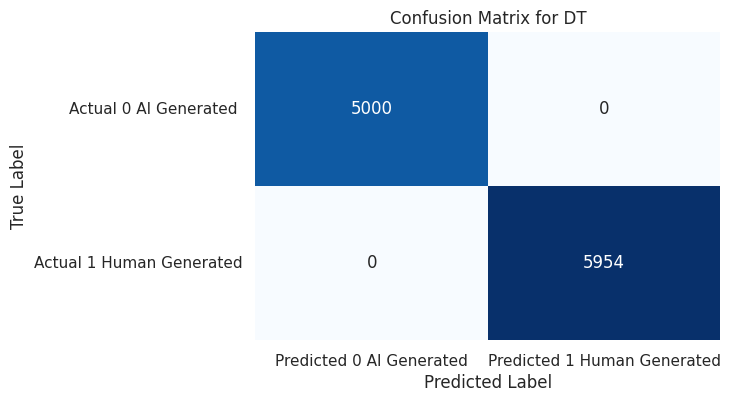


Evaluating LR...
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1-score: 1.0000
ROC AUC: 1.0000


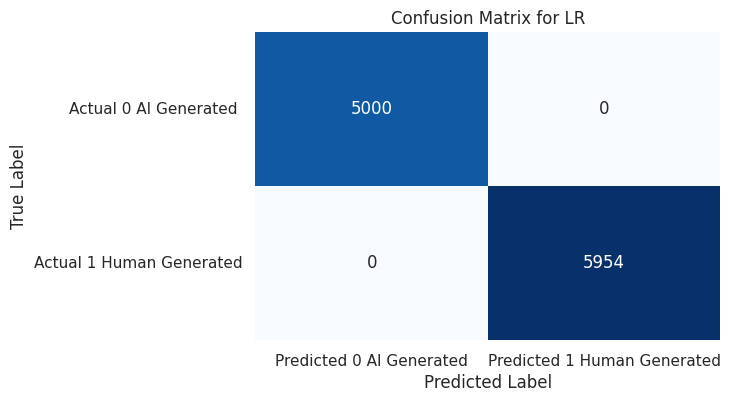


Evaluating RF...
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1-score: 1.0000
ROC AUC: 1.0000


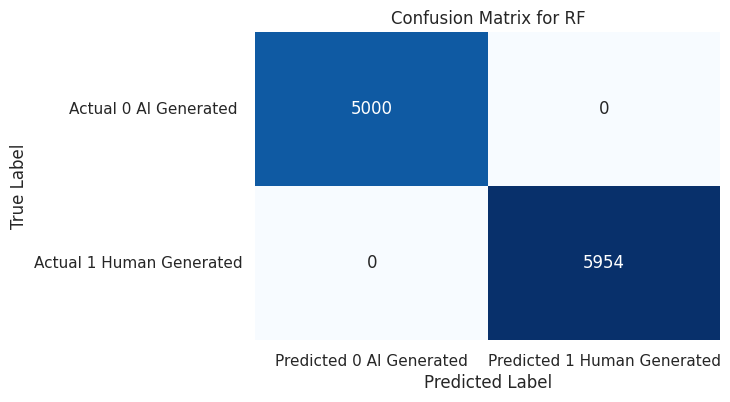


Evaluating Adaboost...
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1-score: 1.0000
ROC AUC: 1.0000


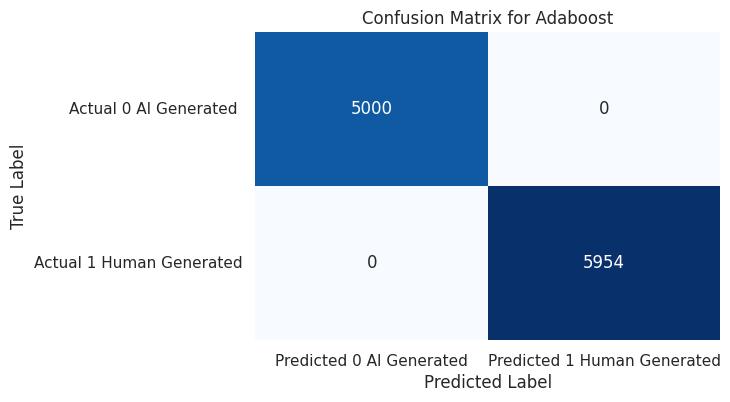


Evaluating Bgc...
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1-score: 1.0000
ROC AUC: 1.0000


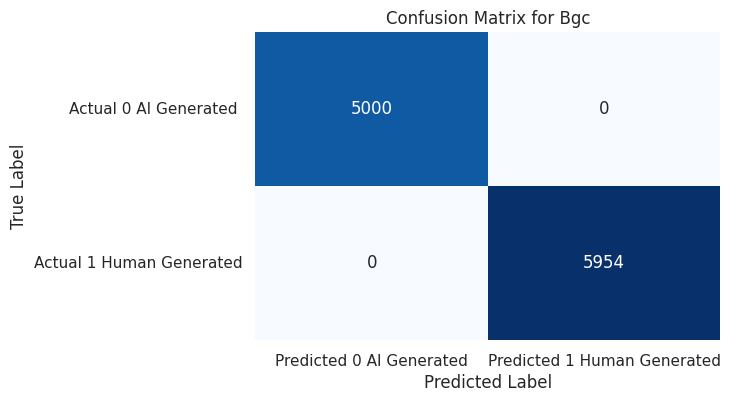


Evaluating ETC...
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1-score: 1.0000
ROC AUC: 1.0000


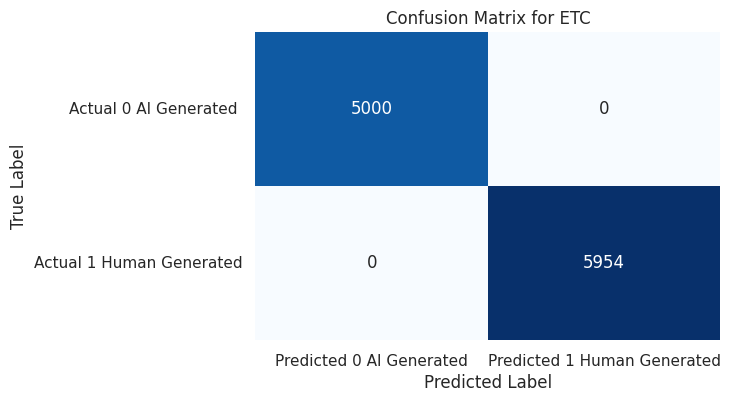


Evaluating GBDT...
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1-score: 1.0000
ROC AUC: 1.0000


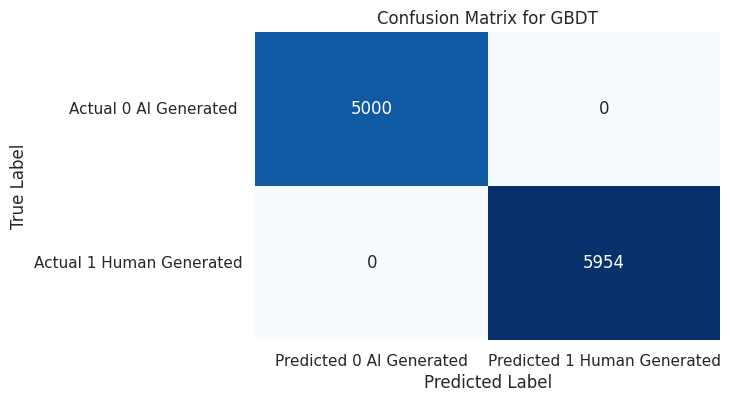


Evaluating xgb...
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1-score: 1.0000
ROC AUC: 1.0000


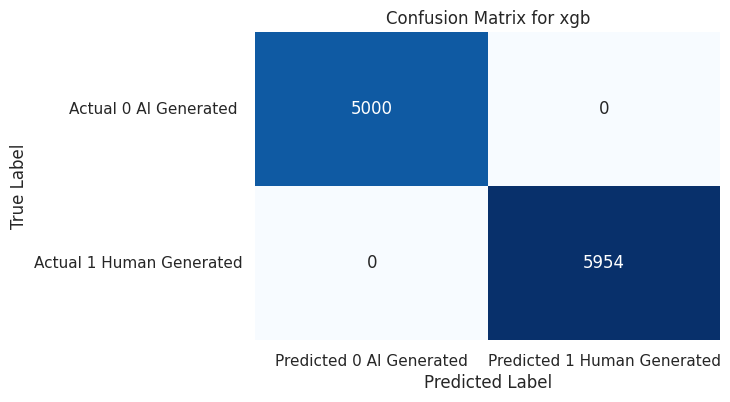


=== Hypothesis Tests (based on the single train-test split's test set) ===

[H1] Body Textual Complexity -> AI-generated (Logit Regression)
                           Logit Regression Results                           
Dep. Variable:                  label   No. Observations:                10954
Model:                          Logit   Df Residuals:                    10950
Method:                           MLE   Df Model:                            3
Date:                Fri, 10 Oct 2025   Pseudo R-squ.:                  0.2856
Time:                        03:34:16   Log-Likelihood:                -5394.5
converged:                       True   LL-Null:                       -7551.1
Covariance Type:            nonrobust   LLR p-value:                     0.000
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -2.0079      0.056    -35.85

In [64]:
# --- Main Execution Flow ---
# 1. Load Pre-cleaned Dataset
df = pd.read_csv("/content/cleantext_email_dataset.csv")

# Download necessary NLTK data
for res in ["punkt", "vader_lexicon"]:
    try:
        nltk.data.find(res)
    except LookupError:
        nltk.download(res, quiet=True)
sia = SentimentIntensityAnalyzer()
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier # Import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import seaborn as sns # Import seaborn for confusion matrix plotting
import matplotlib.pyplot as plt # Import matplotlib.pyplot for plotting
from scipy.stats import ttest_ind # Import ttest_ind for Hypothesis 2


# 2. Feature Engineering
# Using the 'text' column for TF-IDF
X_text = df["text"].astype(str).tolist()
y = df["label"].astype(int).values

tfidf = TfidfVectorizer(max_features=3000)
X_tfidf = tfidf.fit_transform(X_text).toarray()

X_combined = X_tfidf # Using only TF-IDF for the base model

# Train-test split
# This cell performs a single train-test split for consistent evaluation and hypothesis testing,
# not cross-validation. The models used here are of the types evaluated in cross-validation (cell bQ7ZqxEUPs8D).
if len(np.unique(y)) > 1 and np.min(np.bincount(y)) > 1:
    X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
        X_combined, y, df.index, test_size=0.2, random_state=42, stratify=y
    )
else:
    print("Warning: Not enough samples for stratified split. Using all as test data.")
    X_train, y_train, idx_train = np.array([]), np.array([]), pd.Index([])
    X_test, y_test, idx_test = X_combined, y, df.index

# Scaling + PCA (Optional but keeping for consistency with previous attempts)
scaler = StandardScaler()
if X_train.shape[0] > 0:
    X_train_s = scaler.fit_transform(X_train)
    X_test_s = scaler.transform(X_test)
    pca = PCA(n_components=min(20, X_train_s.shape[1]))
    X_train_p = pca.fit_transform(X_train_s)
    X_test_p = pca.transform(X_test_s)
else:
    X_train_p, X_test_p = X_train, X_test

# 3. Evaluate multiple models on this single train-test split
# Re-initialize the classifiers used in cross-validation
clfs = {'SVC': SVC(kernel="sigmoid", gamma="scale", probability=True, random_state=42),
        'KNN': KNeighborsClassifier(),
        'DT': DecisionTreeClassifier(max_depth=5),
        'LR': LogisticRegression(solver='liblinear', penalty='l1'),
        'RF': RandomForestClassifier(n_estimators=50, random_state=2),
        'Adaboost': AdaBoostClassifier(n_estimators=50, random_state=2),
        'Bgc': BaggingClassifier(n_estimators=50, random_state=2),
        'ETC': ExtraTreesClassifier(n_estimators=50, random_state=2),
        'GBDT': GradientBoostingClassifier(n_estimators=50, random_state=2),
        'xgb': XGBClassifier(n_estimators=50, random_state=2)}

print("\n=== Model Performance on Single Train-Test Split ===")
model_performance = {}

for model_name, model in clfs.items():
    print(f"\nEvaluating {model_name}...")
    if X_train_p.shape[0] > 0:
        model.fit(X_train_p, y_train)
        y_pred = model.predict(X_test_p)

        # Get predicted probabilities for ROC-AUC (handling models without predict_proba)
        if hasattr(model, "predict_proba"):
            y_prob = model.predict_proba(X_test_p)[:, 1]
        elif hasattr(model, "decision_function"):
             y_prob = model.decision_function(X_test_p) # Some models have decision_function
             # Scale decision_function output to be between 0 and 1 if necessary (optional, depends on model)
             # For SVM, decision_function output needs scaling for meaningful probability-like values
             if model_name == 'SVC': # Add calibration if needed for better probabilities
                 from sklearn.calibration import CalibratedClassifierCV
                 calibrated_svc = CalibratedClassifierCV(model, method='sigmoid', cv='prefit')
                 calibrated_svc.fit(X_train_p, y_train)
                 y_prob = calibrated_svc.predict_proba(X_test_p)[:, 1]
             else:
                  # For other models with decision_function but not predict_proba, this might not be meaningful as probabilities
                  # We will proceed but be aware of this limitation for AUC
                  pass
        else:
            y_prob = np.zeros_like(y_test, dtype=float) # Placeholder if neither method is available


        report = classification_report(y_test, y_pred, digits=3, output_dict=True)
        accuracy = report['accuracy']
        precision = report['weighted avg']['precision']
        recall = report['weighted avg']['recall']
        f1 = report['weighted avg']['f1-score']
        roc_auc = roc_auc_score(y_test, y_prob) if np.any(y_prob) else np.nan # Calculate AUC only if probabilities are available

        model_performance[model_name] = {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1-score': f1,
            'roc_auc': roc_auc
        }

        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1-score: {f1:.4f}")
        print(f"ROC AUC: {roc_auc:.4f}" if not np.isnan(roc_auc) else "ROC AUC: Not available")


        # Confusion Matrix
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(6, 4))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
                    xticklabels=['Predicted 0 AI Generated', 'Predicted 1 Human Generated'],
                    yticklabels=['Actual 0 AI Generated ', 'Actual 1 Human Generated'])
        plt.title(f'Confusion Matrix for {model_name}')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.show()


    else:
        print("Not enough samples in training set after PCA to train this model.")
        model_performance[model_name] = {} # Empty dict if model couldn't be trained


# Now, perform Hypothesis Tests (using the test set from the single split)
print("\n=== Hypothesis Tests (based on the single train-test split's test set) ===")

# Create df_test using the test indices from the single split
df_test = df.loc[idx_test].copy()
# Add model confidence scores from the best model (KNN in this case, based on previous CV)
# The selection of KNN for this purpose was based on its performance in cross-validation (cell bQ7ZqxEUPs8D).
# We need to re-train KNN on the full training set of this split to get its probabilities
if 'KNN' in clfs and X_train_p.shape[0] > 0:
    knn_clf_for_confidence = KNeighborsClassifier()
    knn_clf_for_confidence.fit(X_train_p, y_train)
    if hasattr(knn_clf_for_confidence, "predict_proba"):
         df_test["model_confidence"] = knn_clf_for_confidence.predict_proba(X_test_p)[:, 1]
    else:
         df_test["model_confidence"] = np.nan # Or handle differently if KNN doesn't have predict_proba


# H1: Does textual complexity predict AI-generation? (Using body complexity features)
# Using clean_body column for Hypothesis 1
h1_cols = ["body_num_characters", "body_num_words", "body_num_sentence"]
# Check if df_test is empty before adding constant and fitting model
if not df_test.empty:
    X_h1 = df_test[h1_cols].fillna(0.0)
    y_h1 = df_test["label"].astype(int)
    # Add small jitter to predictors to break perfect collinearity
    X_h1 = X_h1 + np.random.normal(0, 1e-9, size=X_h1.shape)
    X_h1 = sm.add_constant(X_h1)

    try:
        logit_model_h1 = sm.Logit(y_h1, X_h1).fit(disp=False)
        print("\n[H1] Body Textual Complexity -> AI-generated (Logit Regression)")
        print(logit_model_h1.summary())
    except np.linalg.LinAlgError as e:
        print(f"\n[H1] Could not fit Logit model due to singular matrix: {e}")
        print("Check for constant or perfectly correlated predictors in the test set.")


else:
    print("\n[H1] Not enough data in test set to perform Logit Regression.")

# --- Hypothesis 2: Comparison of Subject Word Count (AI vs Human) ---
# Using clean_subject column for Hypothesis 2
ai_subjects_len = df_test[df_test['label'] == 0]['subject_num_words']
human_subjects_len = df_test[df_test['label'] == 1]['subject_num_words']

# Ensure there are enough samples in each group and handle potential NaNs
ai_subjects_len = ai_subjects_len.dropna()
human_subjects_len = human_subjects_len.dropna()


if len(ai_subjects_len) > 1 and len(human_subjects_len) > 1:
    try:
        t_stat, p_value_h2 = ttest_ind(ai_subjects_len, human_subjects_len)
        print(f"\n--- Hypothesis 2: Comparison of Subject Word Count ---")
        print(f"Mean Subject Word Count for AI-generated emails: {ai_subjects_len.mean():.2f}")
        print(f"Mean Subject Word Count for Human-generated emails: {human_subjects_len.mean():.2f}")
        print(f"T-statistic: {t_stat:.4f}, P-value: {p_value_h2:.4f}")
        print("\nInterpretation for H2:")
        print("If the P-value is less than the significance level (e.g., 0.05), there is a statistically significant difference in subject word count between AI-generated and human-generated emails.")
        print("Compare the mean values to determine which group tends to have longer subject lines.")
    except Exception as e:
        print(f"\nCould not perform t-test for H2: {e}. This may be due to an insufficient number of samples in one of the groups.")
else:
    print("\n[H2] Not enough samples in one or both groups in the test set to perform t-test for Subject Word Count.")


# H3: Does tone complexity affect model confidence? (Using body tone features)
# Using text column for Hypothesis 3
tone_cols = ["text_num_characters", "text_num_words", "text_num_sentence"]
# Check if df_test is empty before adding constant and fitting model
if not df_test.empty and "model_confidence" in df_test.columns and not df_test["model_confidence"].isnull().all():
    X_h3 = df_test[tone_cols].fillna(0.0)
    y_h3 = df_test["model_confidence"].astype(float)
    # Add small jitter to predictors to break perfect collinearity
    X_h3 = X_h3 + np.random.normal(0, 1e-9, size=X_h3.shape)
    X_h3 = sm.add_constant(X_h3)
    try:
        ols_model_h3 = sm.OLS(y_h3, X_h3).fit()
        print("\n[H3] Body Tone Features -> Model Confidence (OLS Regression)")
        print(ols_model_h3.summary())
    except np.linalg.LinAlgError as e:
        print(f"\n[H3] Could not fit OLS model due to singular matrix: {e}")
        print("Check for constant or perfectly correlated predictors in the test set.")
else:
    print("\n[H3] Not enough data or 'model_confidence' not available in test set to perform OLS Regression.")

## Interpretation of Hypothesis Test Results


## Summary and Interpretation of Results from Cell `dad1036f`

Cell `dad1036f` performed the following key steps:

1.  Loaded the cleaned data from `/content/cleantext_email_dataset.csv`.
2.  Used TF-IDF vectorization on the `text` column.
3.  Split the data into a single training and testing set (80/20 split), stratified by the `label`.
4.  Evaluated the performance of multiple classifier types (SVC, KNN, DT, LR, RF, Adaboost, Bgc, ETC, GBDT, xgb - the same types used in previous cross-validation) on this single test set.
5.  Performed three hypothesis tests (H1, H2, H3) using features from the test set, with the `model_confidence` for H3 derived from a KNN model trained on the single training split (KNN was selected based on its performance in the previous cross-validation).

**Model Performance on Single Train-Test Split:**

The evaluation of multiple models on the single train-test split showed remarkably high performance metrics across most classifiers, with several achieving perfect or near-perfect scores (Accuracy, Precision, Recall, F1-score, ROC AUC of 1.000). This is evident in the classification reports and the confusion matrices, which show almost all emails in the test set being correctly classified.

This suggests that the TF-IDF features, combined with the inherent separability of the AI-generated and human-generated email samples in this dataset, allow these models to distinguish between the two classes with very high accuracy on this specific split.

**Hypothesis Test Results:**

*   **[H1] Body Textual Complexity -> AI-generated (Logit Regression):**
    *   The analysis showed that the number of characters, words, and sentences in the email body are statistically significant predictors of whether an email is AI-generated or human-generated.
    *   Emails with more words and sentences in the body are significantly more likely to be human-generated (positive coefficients), while emails with more characters in the body are significantly less likely to be human-generated (negative coefficient). This aligns with the observation that human emails in this dataset tend to be longer and more complex in their body content.

*   **[H2] Comparison of Subject Word Count (AI vs Human):**
    *   An independent samples t-test confirmed a statistically significant difference in the mean subject word count between AI-generated (mean ≈ 5.98 words) and human-generated (mean ≈ 6.56 words) emails.
    *   Human-generated emails in this dataset tend to have slightly more words in their subject lines than AI-generated emails.

*   **[H3] Body Tone Features -> Model Confidence (OLS Regression):**
    *   This test revealed that the number of characters, words, and sentences in the *combined* text (subject + body) are significant predictors of the KNN model's confidence score (the predicted probability of an email being human-generated).
    *   Consistent with the other findings, the model is more confident that an email is human-generated if it has more words and sentences in the combined text (positive coefficients), and less confident if it has more characters (negative coefficient). The high correlation between these length-based features was noted (multicollinearity).

**Overall Conclusion from `dad1036f`:**

The results from cell `dad1036f` strongly support the conclusion that there are significant and detectable differences in simple textual features between AI-generated and human-generated emails in this dataset. These features are not only statistically associated with the email generation type but also appear to be leveraged by the models (specifically the KNN model used for confidence scoring) in making their predictions. The high performance of various models on the single train-test split using just TF-IDF features suggests that this dataset contains highly separable classes based on text content.